In [7]:
#import pandas as pd
#t = pd.read_excel("NNs.xlsx", sheet_name="Sheet4")
#print(t.to_latex( index=False, multirow=True, na_rep=''))

\begin{tabular}{lllll}
\toprule
                              Layer &                 Output Shape & Encoder A & Encoder B & Triplet Embedder \\
\midrule
                              Input &   \$[N\_\{batch\}, 1, 605, 605]\$ &         Y &         Y &                Y \\
                     Convolution+LR &  \$[N\_\{batch\}, 20, 303, 303]\$ &         Y &         Y &                Y \\
       Dropout p=0.2+Convolution+LR &  \$[N\_\{batch\}, 20, 182, 182]\$ &         Y &         Y &                Y \\
           Batch Norm+Dropout p=0.1 &  \$[N\_\{batch\}, 20, 182, 182]\$ &         Y &         Y &                Y \\
                     convolution+LR &    \$[N\_\{batch\}, 20, 74, 74]\$ &         Y &         Y &                Y \\
      Average Pooling+Dropout p=0.1 &    \$[N\_\{batch\}, 20, 38, 38]\$ &         Y &         Y &                Y \\
           Convolution+Batch Norm.  &       \$[N\_\{batch\}, 5, 9, 9]\$ &         Y &         Y &                Y \\
                 Ave

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import torch
from skimage.filters import threshold_local
import sklearn as sk

assert torch.cuda.is_available(), "GPU is not enabled"
# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

def compute_intensity_gravity_center(image):
    """
        Expects input image to be an array of dimensions [h, w].
        It will return an array of gravity centers [2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to numpy indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = np.sum(image, axis=0) # weights for x [raw_width]
    intensity_in_h = np.sum(image, axis=1) # weights for y [raw_height]
    total_intensity = intensity_in_h.sum()

    # Compute mass center for intensity
    # [2] (h_center,w_center)
    return np.nan_to_num( np.stack(
        (np.dot(intensity_in_h, np.arange(image.shape[0]))/total_intensity,
         np.dot(intensity_in_w, np.arange(image.shape[1]))/total_intensity)
        ) )

def compute_raw_to_centered_iX(image, X):

    g_raw = compute_intensity_gravity_center(image)
    # crop the iamges with size (X+1+X)^2 leaving the gravity center in
    # the central pixel of the image. In case the image is not big enough for the cropping,
    # a 0 padding will be made.
    centered_image = np.zeros( (2*X+1, 2*X+1),  dtype = image.dtype )

    # we round the gravity centers to the nearest pixel indices
    g_index_raw = np.rint(g_raw).astype(int) #[N_images, 2]

    # obtain the slicing indices around the center of gravity
    # TODO -> make all this with a single array operation by stacking the lower and upper in
    # a new axis!!
    # [ 2 (h,w)]
    unclipped_lower = g_index_raw[:]-X
    unclipped_upper = g_index_raw[:]+X+1
    # unclippde could get out of bounds for the indices, so we clip them
    lower_bound = np.clip( unclipped_lower, a_min=0, a_max=image.shape)
    upper_bound = np.clip( unclipped_upper, a_min=0, a_max=image.shape)
    # we use the difference between the clipped and unclipped to get the necessary padding
    # such that the center of gravity is left still in the center of the image
    padding_lower = lower_bound-unclipped_lower
    padding_upper = upper_bound-unclipped_upper

    # crop the image
    centered_image[padding_lower[0]:padding_upper[0] or None,
                                    padding_lower[1]:padding_upper[1] or None ] = \
                  image[lower_bound[0]:upper_bound[0],
                                      lower_bound[1]:upper_bound[1]]
    return centered_image



def compute_intensity_gravity_centers_torch( images):
    """
        Expects input image to be an array of dimensions [N_imgs, h, w].
        It will return an array of gravity centers [N_imgs, 2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to array indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = torch.sum(images, dim=1) # weights for x [N_images, raw_width]
    intensity_in_h = torch.sum(images, dim=2) # weights for y [N_images, raw_height]
    total_intensity = intensity_in_h.sum(dim=1) # [N_images]

    # Compute mass center for intensity
    # [N_images, 2] (h_center,w_center)
    return torch.nan_to_num( torch.stack(
        (torch.matmul(intensity_in_h.float(), torch.arange(images.shape[1], 
                                    dtype=torch.float32, device=device))/total_intensity,
         torch.matmul(intensity_in_w.float(), torch.arange(images.shape[2], 
                                    dtype=torch.float32, device=device))/total_intensity),
        dim=1
        ), nan=0.0, posinf=None, neginf=None)


def compute_raws_to_centered_iXs_torch( images, X, device):

    g_raw = compute_intensity_gravity_centers_torch(images) # [ N_images, 2]

    # crop the iamges with size (X+1+X)^2 leaving the gravity center in
    # the central pixel of the image. In case the image is not big enough for the cropping,
    # a 0 padding will be made.
    centered_images = torch.zeros( ( images.shape[0], 2*X+1, 2*X+1),  dtype = images.dtype, 
                                  device=device)

    # we round the gravity centers to the nearest pixel indices
    g_index_raw = torch.round(g_raw).int() #[ N_images, 2]

    # obtain the slicing indices around the center of gravity
    # TODO -> make all this with a single array operation by stacking the lower and upper in
    # a new axis!!
    # [ N_images, 2 (h,w)]
    unclipped_lower = g_index_raw-X
    unclipped_upper = g_index_raw+X+1

    # unclipped could get out of bounds for the indices, so we clip them
    lower_bound = torch.clip( unclipped_lower.float(), min=torch.Tensor([[0,0]]).to(device),
                             max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(device)).int()
    upper_bound = torch.clip( unclipped_upper.float(), min=torch.Tensor([[0,0]]).to(device),
                             max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(device)).int()
    # we use the difference between the clipped and unclipped to get the necessary padding
    # such that the center of gravity is left still in the center of the image
    padding_lower = lower_bound-unclipped_lower
    padding_upper = upper_bound-unclipped_upper

    # crop the image
    for im in range(g_raw.shape[0]):
        centered_images[im, padding_lower[ im, 0]:padding_upper[ im, 0] or None,
                                    padding_lower[ im, 1]:padding_upper[ im, 1] or None] = \
                  images[im, lower_bound[ im, 0]:upper_bound[ im, 0],
                                      lower_bound[ im, 1]:upper_bound[ im, 1]]

    return centered_images

def normalize_to_max_saturate_and_iX_torch(images,  in_are_dev_float, saturation_threshold, 
                                           device, dtype=torch.float32, X=302): # threshold is in [0,1] of max
                                                              # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    maxs = images.abmax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
    images = torch.where(images<maxs*saturation_threshold, images, 0.0)/maxs
    return compute_raws_to_centered_iXs_torch( images, X, device)

def normalize_to_mean_saturate_to_max_and_iX_torch(images,  in_are_dev_float, saturation_threshold, 
                                           device, dtype=torch.float32, X=302):  # threshold is in [0,1] of max
                                                                # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    maxs = images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
    images = torch.where(images<maxs*saturation_threshold, images, 0.0)/torch.mean(images, axis=(-1,-2), keepdims=True)
    return compute_raws_to_centered_iXs_torch( images, X, device)


def normalize_to_mean_saturate_to_mean_and_iX_torch(images,  in_are_dev_float, saturation_threshold, 
                                           device, dtype=torch.float32, X=302):  # threshold is in [0,1] of max
                                                                # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    means=torch.mean(images, axis=(-1,-2), keepdims=True)
    images = np.where(images<means*saturation_threshold, images, 0.0)/means
    return compute_raws_to_centered_iXs_torch( images, X, device)

def normalize_to_max_and_iX_torch(images, in_are_dev_float, 
                                device, dtype=torch.float32, X=302): # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    return compute_raws_to_centered_iXs_torch(images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)), X, device)


def normalize_to_mean_and_iX_torch(images, in_are_dev_float, 
                                device, dtype=torch.float32, X=302): # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    return compute_raws_to_centered_iXs_torch(images/torch.mean(images, axis=(-1,-2), keepdims=True), X, device)


def sigmoid_lut_using_numpy_normalize_and_iX( images, in_are_dev, device, center=0.5, 
                       slope_squeezeness=0.085, max_val_lut_process=255, lut_process_dtype=torch.uint8,
                       output_dtype=torch.float64, X=302 ):
    if not in_are_dev:
        images = images.to(device)
    images = (max_val_lut_process*(images.type(torch.float64)/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)))
                 ).type(lut_process_dtype)
    
    lut = (max_val_lut_process/(1+np.exp(-slope_squeezeness*(np.arange(max_val_lut_process+1)-
                                                               center*max_val_lut_process))))
    images = torch.from_numpy(lut[ images.to('cpu').numpy() ]).to(device).type(output_dtype)
    return compute_raws_to_centered_iXs_torch(images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)), X, device)
# Ojo! se usan los valores float del lut como valores de la imagen! (no los cuantizados!)

def sigmoid_no_lut_normalize_and_iX( images, in_are_dev_float, device, center=0.7, 
                       slope_squeezeness=50, dtype=torch.float64, X=302 ):
    if not in_are_dev_float:
        images = images.type(dtype).to(device)    
    images = images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))   # normalize
    images = 1.0/(1+torch.exp(-slope_squeezeness*(images-center)))
    return compute_raws_to_centered_iXs_torch(images, X, device) # we need not noramlize them again if center if sigmoid chosen with sense


Using device cuda:0


In [2]:
# Sub_block specific stuff ########################
current_sub_block=11
if current_sub_block==1: # ein in torch and not in torch bersioak, eta ein danak por batches procesetie!!!
    # to max noisy and iX
    def preprocess_fct(images, X, batch_size=200, dtype=torch.float64):
        images = images.astype(np.float64)
        ims_out=np.zeros((len(images), 2*X+1, 2*X+1), dtype=np.float64)
        for j in range(0, images.shape[0], batch_size):
            ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
            ims_out[j:(j+batch_size)] = (compute_raws_to_centered_iXs_torch(
                    ims_t/(ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)),
                X=X, device=device)).to('cpu').numpy()
        return ims_out




elif current_sub_block==2:
    # to max then to mean noisy and iX
    def preprocess_fct(images, X, batch_size=200, dtype=torch.float64):
        images = images.astype(np.float64)
        ims_out=np.zeros((len(images), 2*X+1, 2*X+1), dtype=np.float64)
        for j in range(0, images.shape[0], batch_size):
            ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
            ims_t = ims_t/torch.mean(ims_t, axis=(-1,-2), keepdims=True)
            ims_out[j:(j+batch_size)] = (compute_raws_to_centered_iXs_torch(
                ims_t/(ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)),
                     X=X, device=device)).to('cpu').numpy()
        return ims_out


elif current_sub_block==3:
    # to saturate at 0.05 noisy and iX
    def preprocess_fct( images, X, saturation_threshold=0.15, batch_size=200, dtype=torch.float64 ):
        images = images.astype(np.float64)
        ims_out=np.zeros((len(images), 2*X+1, 2*X+1), dtype=np.float64)
        for j in range(0, images.shape[0], batch_size):
            ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
            ims_t = ims_t/ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
            ims_out[j:(j+batch_size)] = compute_raws_to_centered_iXs_torch(
                (torch.where(
                ims_t<=saturation_threshold, ims_t, saturation_threshold)/saturation_threshold), X, device).to('cpu').numpy()
        return ims_out

elif current_sub_block>=4 and current_sub_block<=8:
    # sigmoid lut noisy

    centers = [0.1, 0.3, 0.5, 0.7, 0.9]
    ks = [35, 35, 35, 35, 35]
    for j,k in enumerate(ks):
        ks[j] = np.log(254)/centers[j] if k<np.log(254)/centers[j]  else k
        ks[j] = np.log(254)/(1-centers[j]) if k<np.log(254)/(1-centers[j]) else k

    def preprocess_fct(images, X, center=centers[current_sub_block-4],
                slope_squeezeness=ks[current_sub_block-4], dtype=torch.float64, batch_size=200):
        images = images.astype(np.float64)
        ims_out=np.zeros((len(images), 2*X+1, 2*X+1), dtype=np.float64)
        for j in range(0, images.shape[0], batch_size):
            ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
            ims_t = ims_t/(ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))   # normalize
            ims_out[j:(j+batch_size)] = compute_raws_to_centered_iXs_torch(
                    1.0/(1+torch.exp(-slope_squeezeness*(ims_t-center)))
                                                  , X, device).to('cpu').numpy()
        return ims_out

elif current_sub_block>=9 and current_sub_block<=11:
    # Opening to max to mean
    structs = [7, 9, 11 ]#, 13]

    def to_max_to_mean(images, X, batch_size=200, dtype=torch.float64):
        images = images.astype(np.float64)
        ims_out=np.zeros((len(images), 2*X+1, 2*X+1), dtype=np.float64)

        for j in range(0, images.shape[0], batch_size):
            ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
            ims_t = ims_t/torch.mean(ims_t, axis=(-1,-2), keepdims=True)
            ims_out[j:(j+batch_size)] = (compute_raws_to_centered_iXs_torch(
                ims_t/(ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)),
                     X=X, device=device)).to('cpu').numpy()
        return ims_out
    def get_struct(size, N):
        foot = morphology.disk(size)
        return np.repeat(foot[np.newaxis, :,:], N, axis=0)

    preprocess_fct = lambda ims, X : to_max_to_mean(
        np.array([morphology.opening(im, morphology.disk(structs[current_sub_block-9]) ) for im in ims ]), X)

elif current_sub_block>=12 and current_sub_block<=14:
    # local binarization    
    block_sizes=[21,27, 47 ]
    def to_gravicenter(images, X, batch_size=200, dtype=torch.float64):
        images = images.astype(np.float64)
        ims_out=np.zeros((len(images), 2*X+1, 2*X+1), dtype=np.float64)

        for j in range(0, images.shape[0], batch_size):
            ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
            ims_out[j:(j+batch_size)] = (compute_raws_to_centered_iXs_torch(
                    ims_t, X=X, device=device)).to('cpu').numpy()
        return ims_out
    local_threshold_binarization=lambda im: im < threshold_local(
        im, block_size=block_sizes[current_sub_block-12], offset=10)
    preprocess_fct= lambda ims: to_gravicenter(1.0*np.array([ local_threshold_binarization(im) for im in ims]))


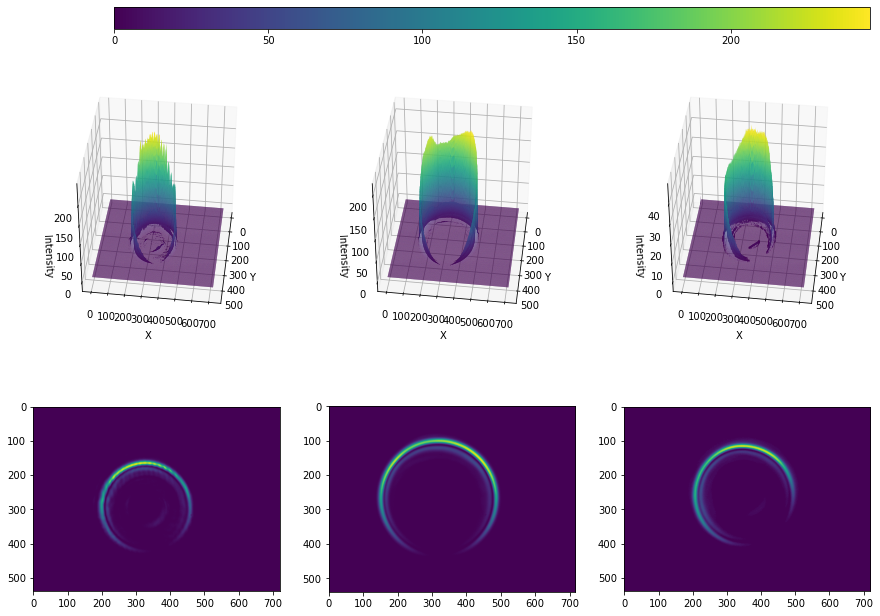

In [1]:
import cv2
from skimage import morphology

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib notebook

in_path = "/home/melanie/Desktop/Conical_Refraction_Polarimeter/REPORT/Figures/"
im_names=["noise1.png", "noise2.png", "noise4.png"]
out_im="noisee.png"
rots=[7, 7, 7]
Xs=[302, 402, 302]

fig = plt.figure(figsize=(15, 10))
bat=False
for k,im_n in enumerate(im_names):
    im = cv2.imread(in_path+im_n, cv2.IMREAD_ANYDEPTH)
    #im = im.astype(np.float64)/im.max()
    #im = preprocess_fct(im[np.newaxis,:,:], Xs[k])[0]
    if im is None:
        print(f" Unable to import image {in_path+im_n}")
        raise ValueError

    plot3d_resolution=1
    prof_x=np.sum(im, axis=0)
    prof_y=np.sum(im, axis=1)
    ax = fig.add_subplot(int(f"23{k+1}"), projection='3d')
    X,Y = np.meshgrid(np.arange(len(prof_y)),np.arange(len(prof_x)))
    #fig.suptitle(f"Intesity Profiles for")# Image\n{image_full_path.split('/')[-1]}")
    theta=25
    phi=30
    cm = ax.plot_surface(X, Y, im.T, rcount=int(len(prof_y)*plot3d_resolution), ccount=int(len(prof_x)*plot3d_resolution), cmap='viridis', alpha=1) # rstride=1, cstride=1, linewidth=0
    if not bat:
        bat=True
        cbax=fig.add_axes([0.2,0.95,0.7,0.03])
        fig.colorbar(cm, ax=ax, cax=cbax, orientation='horizontal')

    #cset = ax.contourf(X, Y, im, 2, zdir='z', offset=-20, cmap='viridis', alpha=0.5)
    #cset = ax.contourf(X, Y, im, 1, zdir='x', offset=-8, cmap='viridis')
    #cset = ax.contourf(X, Y, im, 1, zdir='y', offset=0, cmap='viridis')
    ax.set_xlabel('Y')
    #ax.set_xlim(-8, 8)
    ax.set_ylabel('X')
    #ax.set_ylim(-10, 8)
    ax.set_zlabel('Intensity')
    ax.set_zlim(-0.078*np.max(im), np.max(im))
    #ax.set_title("Image intensity 3D plot")
    ax.view_init(40, rots[k])
    #ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.3, 1.3, 1.3, 1]))

    ax = fig.add_subplot(int(f"23{3+k+1}"))

    ax.imshow(im)
plt.savefig(in_path+f"/{out_im}.png", dpi=500)
plt.show()

In [3]:
import scipy
import skopt
import sklearn.linear_model
def get_least_square_error(center_h_w, im, ransac, theta_N, rad_N, max_rad, rad_scaling, interpol_order, ransac_opts=None): # get the least square error of a fit with a 
    # y=Acos**2(x/2-phi0)+B=b0+b1 cos(x)+b2 sin(x) if b0=A/2+B; b1=A/2 cos(2phi0); b2=A/2sin(2phi0)
    im_polar = warp_polar(im, center=center_h_w, 
                    output_shape=(theta_N, rad_N), 
                    radius=max_rad,
                    scaling=rad_scaling,
                    order=interpol_order)
    hist = im_polar.sum(axis=1)
    #hist = hist/hist.sum()
    supp_phis = np.linspace(0, np.pi*2, theta_N)
    A = np.vstack((np.ones(len(hist)), np.cos(supp_phis), np.sin(supp_phis))).T
    if not ransac:
        betas, ls_res = np.linalg.lstsq( A, hist, rcond=None)[:2]
    else:
        betas = sk.linear_model.RANSACRegressor(base_estimator=sklearn.linear_model.LinearRegression(),
                    min_samples=ransac_opts['min_samples'], max_trials=ransac_opts['max_trials'], 
                    residual_threshold=ransac_opts['residual_threshold'],
                    #stop_n_inliers=inf, stop_score=inf, stop_probability=0.99, loss='absolute_error',
                    random_state=666)
        betas = betas.fit(A[:,1:], hist)
        ls_res = betas.score(A[:,1:], hist) 
    #print(f"LS res {ls_res*(1-w)}")
    return np.sum(ls_res), betas, hist

def rotate_image_by( image_array, angle, center,interpolation_flag):
        """
        Center is expected to be a point [h,w]
        """
        a=np.cos(angle)
        b=np.sin(angle)
        rot_mat=np.float64([[a, b, center[1]*(1-a)-center[0]*b],
                             [-b, a, center[1]*b+center[0]*(1-a)]])
        return cv2.warpAffine(image_array, rot_mat, image_array.shape, flags=interpolation_flag).astype(image_array.dtype)
     
        
def get_Carles_metric(center_h_w, im,  interpolation_flag):
    im_pi_im = rotate_image_by(im, np.pi, center_h_w,interpolation_flag)+im
    '''
    print("original")
    plt.imshow(im)
    plt.show()
    print("pi rotation")
    plt.imshow(rotate_image_by(im, np.pi, center_h_w,interpolation_flag))
    plt.show()
    print("orig+piRot")
    plt.imshow(im_pi_im)
    plt.show()
    print("orig+pirot PI/2")
    plt.imshow(rotate_image_by(im_pi_im, np.pi/2, center_h_w,interpolation_flag))
    plt.show()
    '''
    #print(f"Carles {bai*w}")
    return np.mean(np.abs(im_pi_im-rotate_image_by(im_pi_im, np.pi/2, center_h_w,interpolation_flag)))
    


def run_squared_cosine_fit_and_Carles(references, problems, image_pair_names, 
                                      preprocess_fct, get_grav_fct, squared_cosine_alg_kw_args):
    predicted_deltaPhiCRs={}
    times={}
    if preprocess_fct is not None:
        images = preprocess_fct( np.concatenate((references, problems), axis=0) )
    else:
        images = np.concatenate((references, problems), axis=0)

    references = images[:references.shape[0]]
    problems = images[references.shape[0]:]

    if get_grav_fct:
        centers_pbs = get_grav_fct(problems) #[N_pbs, 2]
        centers_refs = get_grav_fct(references)
    else:
        centers_pbs = np.repeat(np.array([[polar_hist_alg_kw_args['X'], 
                                          polar_hist_alg_kw_args['X']]]), 
                               len(problems), axis=0)
        centers_refs = np.repeat(np.array([[polar_hist_alg_kw_args['X'], 
                                          polar_hist_alg_kw_args['X']]]), 
                               len(references), axis=0)
    
    if type(references)==torch.Tensor or type(problems)==torch.Tensor:
        references = references.to('cpu').numpy()
        problems = problems.to('cpu').numpy()

    predicted_deltaPhiCRs={}
    times={}
    rows_prec = np.broadcast_to( np.arange(references.shape[1]), (references.shape[1],references.shape[1])).swapaxes(0,1) #[h,w]
    # run it
    get_fit = lambda c_h_w, im : get_least_square_error(c_h_w, im, ransac=squared_cosine_alg_kw_args['ransac'],
                                            ransac_opts=squared_cosine_alg_kw_args['ransac_opts'],
                                            theta_N=squared_cosine_alg_kw_args['theta_N'],
                                            rad_N=squared_cosine_alg_kw_args['rad_N'],
                                            max_rad=squared_cosine_alg_kw_args['max_rad'],
                                            rad_scaling=squared_cosine_alg_kw_args['rad_scaling'], 
                                            interpol_order=squared_cosine_alg_kw_args['interpolation_order'])
    w = squared_cosine_alg_kw_args['w']

    if w==1:
        get_metric = lambda c_h_w, im : get_Carles_metric(c_h_w, im, interpolation_flag=cv2.INTER_CUBIC)
    elif w==0:
        get_metric = lambda c_h_w, im : (1-w)*get_least_square_error(c_h_w, im, ransac=False,
                                            theta_N=squared_cosine_alg_kw_args['theta_N'],
                                            rad_N=squared_cosine_alg_kw_args['rad_N'],
                                            max_rad=squared_cosine_alg_kw_args['max_rad'],
                                            rad_scaling=squared_cosine_alg_kw_args['rad_scaling'], 
                                            interpol_order=squared_cosine_alg_kw_args['interpolation_order'])[0]
    else:
        get_metric = lambda c_h_w, im : (1-w)*get_least_square_error(c_h_w, im, ransac=False,
                                            theta_N=squared_cosine_alg_kw_args['theta_N'],
                                            rad_N=squared_cosine_alg_kw_args['rad_N'],
                                            max_rad=squared_cosine_alg_kw_args['max_rad'],
                                            rad_scaling=squared_cosine_alg_kw_args['rad_scaling'], 
                                            interpol_order=squared_cosine_alg_kw_args['interpolation_order'])[0]+\
                                    w*get_Carles_metric(c_h_w, im, interpolation_flag=cv2.INTER_CUBIC)
    

    if squared_cosine_alg_kw_args['method']!='Bayesian':
        options={'maxiter':squared_cosine_alg_kw_args['max_it'],
                'maxfev': squared_cosine_alg_kw_args['max_evals']}
        
        if squared_cosine_alg_kw_args['method']=='Nelder-Mead':
            options['xatol']=squared_cosine_alg_kw_args['abs_tol']
            options['fatol']=squared_cosine_alg_kw_args['rel_tol']
        elif squared_cosine_alg_kw_args['method']=='Powell':
            options['xtol']=squared_cosine_alg_kw_args['abs_tol']
            options['ftol']=squared_cosine_alg_kw_args['rel_tol']

        for ref_im, pb_im, cent_ref, cent_pb, imagep_n in zip(references, problems, centers_refs, centers_pbs, image_pair_names):
            t0=time()
            to_opt = lambda c_h_w : get_metric(c_h_w, im=ref_im)

            res = scipy.optimize.minimize(to_opt, cent_ref, method=squared_cosine_alg_kw_args['method'],
                                    bounds=((0,ref_im.shape[0]),(0, ref_im.shape[0])),
                                    #constraints=(), 
                                    tol=None, options=options)
            geom_center_ref = res.x

            #check_results(ref_im, geom_center_ref, cent_ref, get_fit, np.linspace(0, 2*np.pi, squared_cosine_alg_kw_args['theta_N']), squared_cosine_alg_kw_args['ransac'])

            
            to_opt = lambda c_h_w : get_metric(c_h_w, im=pb_im)
            res = scipy.optimize.minimize(to_opt, cent_pb, method=squared_cosine_alg_kw_args['method'],
                                    bounds=((0,pb_im.shape[0]),(0, pb_im.shape[0])),
                                    #constraints=(), 
                                    tol=None, options=options)
            geom_center_pb = res.x
            
            #check_results(pb_im, geom_center_pb, cent_pb, get_fit, np.linspace(0, 2*np.pi, squared_cosine_alg_kw_args['theta_N']), squared_cosine_alg_kw_args['ransac'])
            
            if squared_cosine_alg_kw_args['get_delta_from_grav_geom_centers']:
                ref_ang = np.arctan2(geom_center_ref[0]-cent_ref[0], geom_center_ref[1]-cent_ref[1] )
                pb_ang = np.arctan2(geom_center_pb[0]-cent_pb[0], geom_center_pb[1]-cent_pb[1] )
                
                #no se si ambos, pero hace falta mirar si up or down, ze con gravcentros al menos es up to pi
                ref_angle = get_polarization_angle( ref_ang, ref_im, cent_ref, rows_prec)
                pb_angle = get_polarization_angle( pb_ang, pb_im, cent_pb, rows_prec)

            else:
                er, betas = get_fit(geom_center_ref, ref_im)[:2]
                if squared_cosine_alg_kw_args['ransac']:
                    betas = [np.nan,]+list(betas.estimator_.coef_)
                ref_ang = np.arctan2(betas[2],betas[1])

                er, betas = get_fit(geom_center_pb, pb_im)[:2]
                if squared_cosine_alg_kw_args['ransac']:
                    betas = [np.nan,]+list(betas.estimator_.coef_)
                pb_ang = np.arctan2(betas[2],betas[1]) # probar si poniendo en y and x va bien, y si exige aun asi mirar si es up or down

            check_results(ref_im, geom_center_ref, cent_ref, get_fit, np.linspace(0, 2*np.pi, squared_cosine_alg_kw_args['theta_N']), squared_cosine_alg_kw_args['ransac'])

            found = angle_to_pi_pi(ref_ang)-angle_to_pi_pi(pb_ang)

            predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(found)
            times[imagep_n] = time()-t0
    else:
        for ref_im, pb_im, cent_ref, cent_pb, imagep_n in zip(references, problems, centers_refs, centers_pbs, image_pair_names):
            t0=time()
            to_opt = lambda c_h_w : get_metric(c_h_w, im=ref_im)

            res = skopt.gp_minimize(to_opt, dimensions=((0.0,float(ref_im.shape[0])),(0.0, float(ref_im.shape[0]))),
                                n_calls=squared_cosine_alg_kw_args['max_evals'],
                                x0=[[cent_ref[0],cent_ref[1]]],
                                n_initial_points=10, initial_point_generator='random',
                                acq_func='gp_hedge', acq_optimizer='auto', 
                                random_state=666, 
                                n_points=10000, n_restarts_optimizer=5, xi=0.01, 
                                kappa=1.96, noise='gaussian', n_jobs=squared_cosine_alg_kw_args['n_jobs'])
            geom_center_ref = res.x
            check_results(ref_im, geom_center_ref, cent_ref, get_fit, np.linspace(0, 2*np.pi, squared_cosine_alg_kw_args['theta_N']), squared_cosine_NM_alg_kw_args['ransac'])

            to_opt = lambda c_h_w : get_metric(c_h_w, im=pb_im)
            res = skopt.gp_minimize(to_opt, dimensions=((0.0,float(pb_im.shape[0])),(0.0, float(pb_im.shape[0]))),
                                n_calls=squared_cosine_alg_kw_args['max_evals'],
                                x0=[[cent_pb[0],cent_pb[1]]],
                                n_initial_points=10, initial_point_generator='random',
                                acq_func='gp_hedge', acq_optimizer='auto', 
                                random_state=666, 
                                n_points=10000, n_restarts_optimizer=5, xi=0.01, 
                                kappa=1.96, noise='gaussian', n_jobs=squared_cosine_alg_kw_args['n_jobs'])
            geom_center_pb = res.x
            check_results(pb_im, geom_center_pb, cent_pb, get_fit, np.linspace(0, 2*np.pi, squared_cosine_alg_kw_args['theta_N']), squared_cosine_NM_alg_kw_args['ransac'])

            if squared_cosine_alg_kw_args['get_delta_from_grav_geom_centers']:
                ref_ang = np.arctan2(geom_center_ref[0]-cent_ref[0], geom_center_ref[1]-cent_ref[1] )
                pb_ang = np.arctan2(geom_center_pb[0]-cent_pb[0], geom_center_pb[1]-cent_pb[1] )
            else:
                er, betas = get_fit(geom_center_ref, ref_im)[:2]
                ref_ang = np.arctan2(betas[2]/betas[1],1)

                er, betas = get_fit(geom_center_pb, pb_im)[:2]
                pb_ang = np.arctan2(betas[2]/betas[1],1) # probar si poniendo en y and x va bien, y si exige aun asi mirar si es up or down

            # no se si ambos, pero hace falta mirar si up or down, ze con gravcentros al menos es up to pi
            ref_angle = get_polarization_angle( ref_ang, ref_im, cent_ref, rows_prec)
            pb_angle = get_polarization_angle( pb_ang, pb_im, cent_pb, rows_prec)

            found = angle_to_pi_pi(ref_ang)-angle_to_pi_pi(pb_ang)

            predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(found)
            times[imagep_n] = time()-t0

            
    return predicted_deltaPhiCRs, times

def check_results(im, geom, grav, hist_and_fit_f, supp_phis, ransac):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(im)
    ax[0].plot(geom[1],geom[0], 'or', label="Geometric Center")
    ax[0].plot(grav[1],grav[0], 'oy', label="Gravicenter")
    ax[0].plot([0,im.shape[0]-1],[-grav[1]*(geom[0]-grav[0])/(geom[1]-grav[1])+grav[0], (im.shape[0]-1-grav[1])*(geom[0]-grav[0])/(geom[1]-grav[1])+grav[0]], '-w')
    ax[0].set_xlim((0,im.shape[1]))
    ax[0].set_ylim((0, im.shape[0]))
    
    er, betas, hist = hist_and_fit_f(geom, im)
    if ransac:
        print(f"n trials: {betas.n_trials_} inliers: {np.sum(betas.inlier_mask_)}")
        fit = betas.estimator_.predict(np.vstack(( np.cos(supp_phis), np.sin(supp_phis))).T)
        ax[1].plot(supp_phis[betas.inlier_mask_], np.zeros(np.sum(betas.inlier_mask_)), 'o', markersize=1, label="Inliers")
    else:
        fit = betas[0]+betas[1]*np.cos(supp_phis)+betas[2]*np.sin(supp_phis)
        
    ax[1].plot(supp_phis, hist, label="Histogram at optimal geometric center")
    ax[1].plot(supp_phis, fit, label="Least Squares Fit")
    ax[1].legend()
    ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.55),
          ncol=1, fancybox=True, shadow=True)
    plt.savefig("/home/melanie/Desktop/Conical_Refraction_Polarimeter/REPORT/Figures/bi.png", dpi=500)
    plt.show()
    
     
def given_axis_angle_greater_minus_lower( angle, image, center, rows):
    # such that if the output is positive, then R has more intensity and you know immediately that the good angle is the bigger one?
    # de fet esto sugiere un algoritmo con el polano ortogonal que directamente te encuentra el angulo que toca, pero bueno con los que buscan el eje simetrico el truco no parece que funcionara
    mask=np.less(rows, np.tan(angle)*(rows.swapaxes(0,1)-center[1])+center[0]) #[h,w] We set -angle, because the coordinates we are thinking of are a mirror flip in w
        # also, we use less instead of greater because we are really thinking on the mirror fliped axes on w
    return np.sum(image[mask])-np.sum(image[np.logical_not(mask)])

def get_polarization_angle( angle, image, center, rows):
    """
    All the mirror methods have the problem that we only get the
    correct angle up to an angle pi. In order to know which is the
    angle to the maximum of the ring (and not the minimum) a final
    subtle check is required.
    """
    #if angle==np.pi or 0: In this case the correct one is not defined by this alg!!!
    if angle==0 or abs(angle)==np.pi:
        angle+=1e-12 # this solution is not ideal, but it works, since we will never get such a good precision
    diff=given_axis_angle_greater_minus_lower(angle+np.pi/2, image, center, rows)

    if diff<0: # then Upper>Lower -> then good one is the one in (0,pi)
        return angle+np.pi if angle<0 else angle
    else:
        return angle-np.pi if angle>0 else angle
    

    # comprobar si hace fata poner up-down
    # mirar los plots de los resultados optimos, el histograma contra el ajuste que sale
    # y tb la imagen con el gravicentro, el geometric center y la recta que los une! Esto en plan plot gure dot!
    # Probar si bajas o subes el num de iteraciones y evaluaciones que pasa
    # probar el Powel method!
    
    # Implementar ahora el Bayesian Optimizer y implementar ambos en simulation coordinate descent!
    
    

(605, 605)
n trials: 1 inliers: 3600


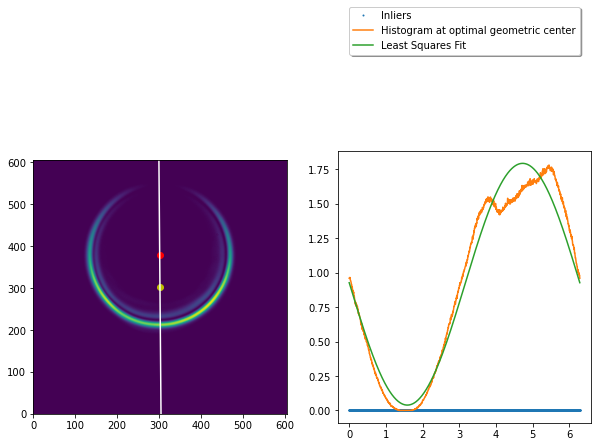

({'un coño no se comerá': 6}, {'un coño no se comerá': 1.9992663860321045})

In [135]:
def preprocess_fct(images, batch_size=200, dtype=torch.float64):
        images = images.astype(np.float64)
        for j in range(0, images.shape[0], batch_size):
            ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
            images[j:(j+batch_size)] = (compute_raws_to_centered_iXs_torch(
                    ims_t/(ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)),
                X=302, device=device)).to('cpu').numpy()
        return images
    
def preprocess_fctUNO(images, X, batch_size=200, dtype=torch.float64):
    images = images.astype(np.float64)
    ims_out=np.zeros((len(images), 2*X+1, 2*X+1), dtype=np.float64)
    for j in range(0, images.shape[0], batch_size):
        ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
        ims_out[j:(j+batch_size)] = (compute_raws_to_centered_iXs_torch(
                ims_t/(ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)),
            X=X, device=device)).to('cpu').numpy()
    return ims_out
def get_gravicentrum_batched(images, batch_size=200):
    gravicenters = np.zeros((images.shape[0], 2), dtype=np.float64)
    for j in range(0, images.shape[0], batch_size):
        gravicenters[j:(j+batch_size)] = compute_intensity_gravity_centers_torch(
            torch.from_numpy(images[j:(j+batch_size)]).to(device)).to('cpu').numpy()

    return gravicenters

from skimage.transform import warp_polar
from time import time
X=302
im = cv2.imread("/home/melanie/Desktop/Conical_Refraction_Polarimeter/REPORT/Figures/datum2.png", cv2.IMREAD_GRAYSCALE)
im = preprocess_fctUNO(im[np.newaxis,:,:], X)[0]
print(im.shape)
#ims=np.array([im, im.copy()])
def angle_to_pi_pi(x):
    return 6

run_squared_cosine_fit_and_Carles( im[np.newaxis,:,:], im[np.newaxis,:,:], ["un coño no se comerá", 'tal'], 
                                      preprocess_fct, get_gravicentrum_batched, 
                {'rad_scaling':'linear', 'interpolation_order':3, 'max_rad':(2*X+1)*2//3, 
                            'theta_N':360*10**1, 'rad_N':50, 
                            'use_exact_gravicenter':True, 'X':X,
                              'method':'Nelder-Mead',
                             'max_it':45, 'max_evals':50, 'abs_tol':0, 'rel_tol':0,
                             'get_delta_from_grav_geom_centers':False, 
                                    'w':1, 'ransac':True, 
                        'ransac_opts':{'min_samples':0.5, 'max_trials':50, 'residual_threshold':0.9}},
                     )


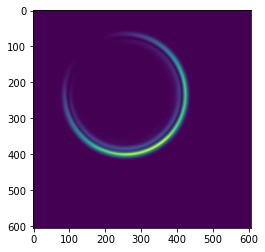

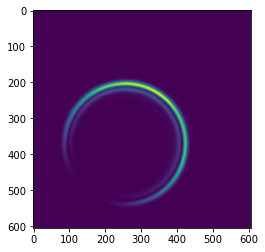

In [70]:
im = cv2.imread("/home/melanie/Desktop/Conical_Refraction_Polarimeter/REPORT/Figures/datum2.png", cv2.IMREAD_GRAYSCALE)
im = preprocess_fctUNO(im[np.newaxis,:,:], X)[0]
im = rotate_image_by( im, np.pi/4, (302,302), cv2.INTER_CUBIC)
imR = im[::-1,:]
plt.imshow(im)
plt.show()
plt.imshow(imR)
plt.show()

In [66]:
from skimage.transform import warp_polar

def run_histogram_intra_class_var(references, problems, image_pair_names, preprocess_fct, 
                            get_grav_fct, polar_hist_alg_kw_args):
    predicted_deltaPhiCRs={}
    times={}
     
    # preprocess the images the image loader:
    if preprocess_fct is not None:
        images = preprocess_fct( np.concatenate((references, problems), axis=0) )
    else:
        images = np.concatenate((references, problems), axis=0)

    references = images[:references.shape[0]]
    problems = images[references.shape[0]:]
    # Execute the Rotation Algorithm:

    if polar_hist_alg_kw_args['use_exact_gravicenter']:
        centers_pbs = get_grav_fct(problems) #[N_pbs, 2]
        centers_refs = get_grav_fct(references)
    else:
        centers_pbs = np.repeat(np.array([[polar_hist_alg_kw_args['X'], 
                                          polar_hist_alg_kw_args['X']]]), 
                               len(problems), axis=0)
        centers_refs = np.repeat(np.array([[polar_hist_alg_kw_args['X'], 
                                          polar_hist_alg_kw_args['X']]]), 
                               len(references), axis=0)
    
    if type(references)==torch.Tensor or type(problems)==torch.Tensor:
        references = references.to('cpu').numpy()
        problems = problems.to('cpu').numpy()

    
    predicted_deltaPhiCRs={}
    times={}
    # run it
    for ref_im, pb_im, cent_ref, cent_pb, imagep_n in zip(references, problems, centers_refs, centers_pbs, image_pair_names):
        t0=time()
        im_ref_polar = warp_polar(ref_im, center=cent_ref, 
                    output_shape=(polar_hist_alg_kw_args['theta_N'],
                                  polar_hist_alg_kw_args['rad_N']), 
                    radius=polar_hist_alg_kw_args['max_rad'],
                    scaling=polar_hist_alg_kw_args['rad_scaling'],
                    order=polar_hist_alg_kw_args['interpolation_order'])
        im_pb_polar = warp_polar(pb_im, center=cent_pb, 
                    output_shape=(polar_hist_alg_kw_args['theta_N'],
                                  polar_hist_alg_kw_args['rad_N']), 
                    radius=polar_hist_alg_kw_args['max_rad'],
                    scaling=polar_hist_alg_kw_args['rad_scaling'],
                    order=polar_hist_alg_kw_args['interpolation_order'])

        
        histR = im_ref_polar.sum(axis=1)
        histR = histR/histR.sum()
        
        histP = im_pb_polar.sum(axis=1)
        histP = histP/histP.sum()
        
        otsu_min_R = mild_brute_force_then_zoom_in(histR, every=len(histR)//100)
        otsu_min_P = mild_brute_force_then_zoom_in(histP, every=len(histP)//100)
        a_shift_is = 360.0/len(histR) # deg
        found = (otsu_min_R-otsu_min_P)*a_shift_is/180*np.pi
        
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(found)
        times[imagep_n] = time()-t0

            
    return predicted_deltaPhiCRs, times

def mild_brute_force_then_zoom_in(hist, every=10):
    filt_hist = hist[::every]
    shift, _, _ = get_optimal_shift_and_otsu_for_that_shift(filt_hist, 0, len(filt_hist))
    shift, otsu_min_angle_shifted, otsu_min = get_optimal_shift_and_otsu_for_that_shift(
        filt_hist, shift*every-every*10, shift*every+every*10)
    thetas = np.linspace(-np.pi, np.pi, len(hist))
    plt.plot(thetas, hist)
    plt.axvline(thetas[otsu_min_angle_shifted], color='red')
    plt.title(f"Shift of {shift*2*np.pi/len(hist):6.3} deg\nMin var ang {thetas[otsu_min_angle_shifted]:6.3}")
    plt.show()
    # this could either be the crest max direction or the minimum one
    # we must convert all to the same, say to the crest max
    if otsu_min < min(hist)+45 and otsu_min>min(hist)-45: # then its the min
        otsu_min += 180
        otsu_min -= 360*(otsu_min>=360)
    return otsu_min # could also work with shift differences!


def get_optimal_shift_and_otsu_for_that_shift(hist, min_shift, max_shift): # hist should be normalized in scale
    otsu_var_per_shift = []
    otsu_angle = []
    bin_centers = list(range(0, len(hist)))
    thetas=np.linspace(-np.pi, np.pi, len(hist))
    for shift in range(min_shift, max_shift):
        hist_s = np.concatenate((hist[shift:], hist[:shift]))
        weight1 = np.cumsum(hist_s)
        weight2 = np.cumsum(hist_s[::-1])[::-1]
        mean1 = np.cumsum(hist_s * bin_centers) / weight1
        mean2 = (np.cumsum((hist_s * bin_centers)[::-1]) / weight2[::-1])[::-1]
        variances = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
        
        minarg = np.argmax(variances)
        otsu_angle.append( bin_centers[minarg] )
        otsu_var_per_shift.append( variances[minarg] )
        if shift==0:
            plt.plot(variances)
            plt.show()
            plt.plot(thetas, hist_s)
            plt.axvline(thetas[minarg], color='red')
            plt.title(f"Shift of {shift*2*np.pi/len(hist):6.3} deg\nMin var ang {thetas[minarg]:6.3}")
            plt.show()

    min_var_shift = np.nanargmax(otsu_var_per_shift)
    opt_otsu_angle = otsu_angle[min_var_shift]
    min_var_shift+=min_shift
    in_shifted = opt_otsu_angle//(len(hist)-min_var_shift)>0
    return min_var_shift, opt_otsu_angle, opt_otsu_angle + min_var_shift-len(hist)*in_shifted # the optimal shift, the opt_angle in the optimal shift and this angle but relative to the first image
    # it should happen that the shift difference and the optimal angle relative to the unshifted, difference are the same phiCR difference

(605, 605)


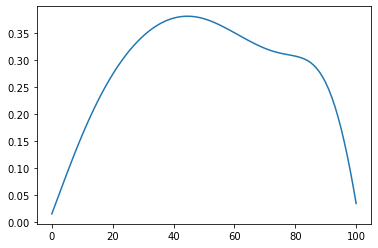

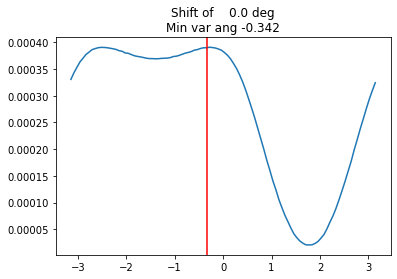

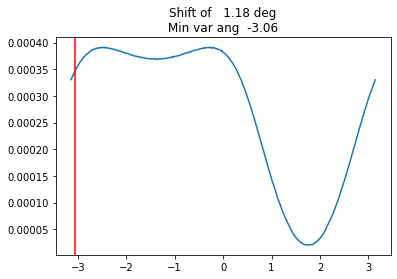

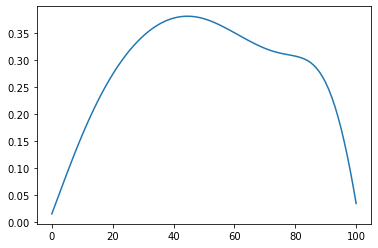

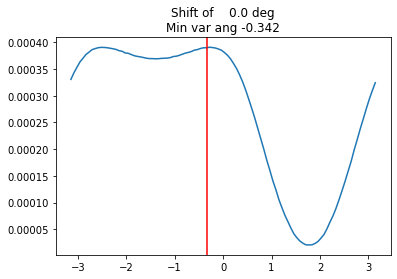

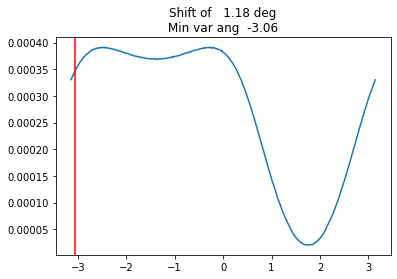

({'un coño no se comerá': 6}, {'un coño no se comerá': 1.398127794265747})

In [67]:
def preprocess_fct(images, batch_size=200, dtype=torch.float64):
        images = images.astype(np.float64)
        for j in range(0, images.shape[0], batch_size):
            ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
            images[j:(j+batch_size)] = (compute_raws_to_centered_iXs_torch(
                    ims_t/(ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)),
                X=302, device=device)).to('cpu').numpy()
        return images
    
def preprocess_fctUNO(images, X, batch_size=200, dtype=torch.float64):
    images = images.astype(np.float64)
    ims_out=np.zeros((len(images), 2*X+1, 2*X+1), dtype=np.float64)
    for j in range(0, images.shape[0], batch_size):
        ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
        ims_out[j:(j+batch_size)] = (compute_raws_to_centered_iXs_torch(
                ims_t/(ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)),
            X=X, device=device)).to('cpu').numpy()
    return ims_out
def get_gravicentrum_batched(images, batch_size=200):
    gravicenters = np.zeros((images.shape[0], 2), dtype=np.float64)
    for j in range(0, images.shape[0], batch_size):
        gravicenters[j:(j+batch_size)] = compute_intensity_gravity_centers_torch(
            torch.from_numpy(images[j:(j+batch_size)]).to(device)).to('cpu').numpy()

    return gravicenters

from skimage.transform import warp_polar
from time import time
X=302
im = cv2.imread("/home/melanie/Desktop/Conical_Refraction_Polarimeter/REPORT/Figures/datum2.png", cv2.IMREAD_GRAYSCALE)
im = preprocess_fctUNO(im[np.newaxis,:,:], X)[0]
print(im.shape)
#ims=np.array([im, im.copy()])
def angle_to_pi_pi(x):
    return 6

run_histogram_intra_class_var( im[np.newaxis,:,:], im[np.newaxis,:,:], ["un coño no se comerá", 'tal'], 
                                      preprocess_fct, get_gravicentrum_batched, 
    polar_hist_alg_kw_args = {'rad_scaling':'linear', 'interpolation_order':3, 'max_rad':(2*X+1)*2//3, \
                            'theta_N':365*10**1, 'rad_N':50, \
                            'use_exact_gravicenter':True, 'X':X},
                     )


In [93]:
#gradient_resgression_alg_kw_args = {'gravicenter_alg': normalize_to_max_and_iX}

# input images expected for all cases to be float64 and normalized to unity
# also, at least in this case, expected to be numpy arrays!
# Input expected to be alread [n, 2X+1, 2X+1] centered in gravicenter!
def run_gradient_regression(references, problems, image_pair_names, preprocess_fct):
    predicted_deltaPhiCRs={}
    times={}
    
    # preprocess the images the image loader:
    if preprocess_fct is not None:
        images = preprocess_fct( np.concatenate((references, problems), axis=0) )
    else:
        images = np.concatenate((references, problems), axis=0)

    references = images[:references.shape[0]]
    problems = images[references.shape[0]:]
    
    if type(references)==torch.Tensor or type(problems)==torch.Tensor:
        references = references.to('cpu').numpy()
        problems = problems.to('cpu').numpy()

    
    predicted_deltaPhiCRs={}
    times={}
    rows_prec = np.broadcast_to( np.arange(references.shape[1]), (references.shape[1],references.shape[1])).swapaxes(0,1) #[h,w]
    # run it
    for ref_im, pb_im, imagep_n in zip(references, problems, image_pair_names):
        t0=time()
        
        ref_ang = compute_gradient_regression_estimate(ref_im, rows_prec)
        pb_ang = compute_gradient_regression_estimate(pb_im, rows_prec)

        found = angle_to_pi_pi(ref_ang)-angle_to_pi_pi(pb_ang)
        
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(found)
        times[imagep_n] = time()-t0

            
    return predicted_deltaPhiCRs, times


def given_axis_angle_greater_minus_lower( angle, image, center, rows):
    # such that if the output is positive, then R has more intensity and you know immediately that the good angle is the bigger one?
    # de fet esto sugiere un algoritmo con el polano ortogonal que directamente te encuentra el angulo que toca, pero bueno con los que buscan el eje simetrico el truco no parece que funcionara
    mask=np.less(rows, np.tan(angle)*(rows.swapaxes(0,1)-center[1])+center[0]) #[h,w] We set -angle, because the coordinates we are thinking of are a mirror flip in w
        # also, we use less instead of greater because we are really thinking on the mirror fliped axes on w
    return np.sum(image[mask])-np.sum(image[np.logical_not(mask)])

def get_polarization_angle( angle, image, center, rows):
    """
    All the mirror methods have the problem that we only get the
    correct angle up to an angle pi. In order to know which is the
    angle to the maximum of the ring (and not the minimum) a final
    subtle check is required.
    """
    #if angle==np.pi or 0: In this case the correct one is not defined by this alg!!!
    if angle==0 or abs(angle)==np.pi:
        angle+=1e-12 # this solution is not ideal, but it works, since we will never get such a good precision
    diff=given_axis_angle_greater_minus_lower(angle+np.pi/2, image, center, rows)

    if diff<0: # then Upper>Lower -> then good one is the one in (0,pi)
        return angle+np.pi if angle<0 else angle
    else:
        return angle-np.pi if angle>0 else angle
    
    
def compute_intensity_gravity_center(image):
    """
        Expects input image to be an array of dimensions [h, w].
        It will return an array of gravity centers [2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to numpy indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = np.sum(image, axis=0) # weights for x [raw_width]
    intensity_in_h = np.sum(image, axis=1) # weights for y [raw_height]
    total_intensity = intensity_in_h.sum()

    # Compute mass center for intensity
    # [2] (h_center,w_center)
    return np.nan_to_num( np.stack(
        (np.dot(intensity_in_h, np.arange(image.shape[0]))/total_intensity,
         np.dot(intensity_in_w, np.arange(image.shape[1]))/total_intensity)
        ) )

def compute_gradient_regression_estimate( im, rows_prec ):
    #diag = np.sqrt( im.shape[0]**2+im.shape[1]**2 )
    mask_radii = np.linspace(100, int(im.shape[1])/2, int(im.shape[1]/2))
    found_gravs = np.zeros((mask_radii.shape[0], 2))
    hs, ws = np.arange(im.shape[0]), np.arange(im.shape[1])
    full_grav = compute_intensity_gravity_center(im)
    radii_image =  np.sqrt((hs[:,np.newaxis]-full_grav[0])**2+(ws[np.newaxis,:]-full_grav[1])**2) # should be [H,W]
    for j, radi in enumerate(mask_radii):
        found_gravs[j,:] = compute_intensity_gravity_center(
                np.where(radii_image<radi, im, 0).astype(np.float64))
    betas = np.linalg.lstsq(
                np.vstack((np.ones(len(found_gravs)), found_gravs[:,1])).T, 
                found_gravs[:, 0],rcond=None)[0]
    f, ax = plt.subplots(1,1, figsize=(10,10))
    ax.imshow(im)
    ax.plot(found_gravs[::40,1], found_gravs[::40,0], 'ow', markersize=6)
    ax.plot([0,604],[betas[0], betas[0]+betas[1]*604], '-w')
    ax.set_ylim((0,604))
    ax.set_xlim((0,604))
    plt.show()
    return get_polarization_angle( np.arctan2(betas[1],1), im, full_grav, rows_prec)

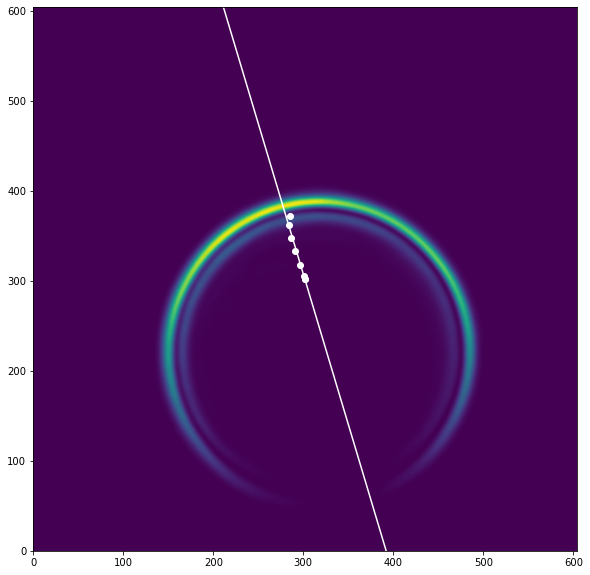

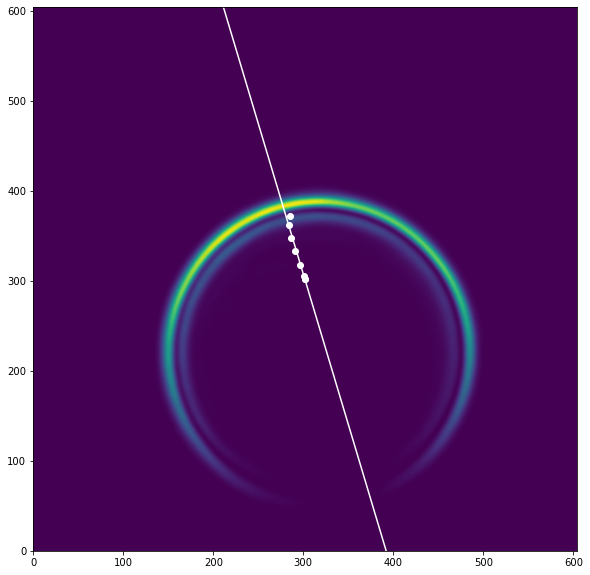

({'un coño no se comerá': 6}, {'un coño no se comerá': 1.6874668598175049})

In [94]:
X=302
im = cv2.imread("/home/melanie/Desktop/Conical_Refraction_Polarimeter/REPORT/Figures/datum2.png", cv2.IMREAD_GRAYSCALE)
im = preprocess_fctUNO(im[np.newaxis,:,:], X)[0]

run_gradient_regression(  im[np.newaxis,:,:], im[np.newaxis,:,:], ["un coño no se comerá", 'tal'], preprocess_fct)